In [1]:
from fitCausalInferenceMonteCarlo import *
import numpy as np
import pandas as pd
import loadData

In [2]:
data, dataName = loadData.loadData("dt_all.csv")



 Total trials before cleaning
: 2226
uniqueSensory: [0.1 1.2] 
 uniqueStandard: [0.5] 
 uniqueConflict: [-0.25, -0.17, -0.08, 0.0, 0.08, 0.17, 0.25]

0  trials with testDurSCheck False
0  trials with standardDurCheck False

0  trials with abs(testDurSCompare) > 0.05
0  trials with abs(standardDurCompare) > 0.05

0  trials with testDurSCheckBias False
0  trials with negative visual test duration
0  trials with negative visual standard duration
testdurCompare > 0.05: 0 trials
0  trials with negative visual standard duration
0  trials with negative visual test duration
total trials after cleaning: 2226


/opt/miniconda3/envs/mathmod/lib/python3.11/site-packages/pandas/core/arraylike.py:399: RuntimeWarning: divide by zero encountered in log
  result = getattr(ufunc, method)(*inputs, **kwargs)
/opt/miniconda3/envs/mathmod/lib/python3.11/site-packages/pandas/core/arraylike.py:399: RuntimeWarning: invalid value encountered in log
  result = getattr(ufunc, method)(*inputs, **kwargs)


In [3]:
intensityVariable="deltaDurS"

sensoryVar="audNoise"
standardVar="standardDur"
conflictVar="conflictDur"

# true stim vars to group by
visualStandardVar="unbiasedVisualStandardDur"
visualTestVar="unbiasedVisualTestDur"
audioStandardVar="standardDur"
audioTestVar="testDurS"

# unique values for each variable
groupedData = groupByChooseTest(data, [intensityVariable, sensoryVar, standardVar, conflictVar,visualStandardVar, visualTestVar, audioTestVar])
uniqueIntensity = sorted(data[intensityVariable].unique())
uniqueStandard= groupedData[standardVar].unique()
uniqueSensory = groupedData[sensoryVar].unique()
uniqueConflict = sorted(groupedData[conflictVar].unique())


timeStart = time.time()
print(f"\nFitting Causal Inference Model for {dataName} with {len(groupedData)} unique conditions")
#fittedParams = fitCausalInferenceMonteCarlo(groupedData,nStart=1)
print(f"\nFitted parameters for {dataName}: {fittedParams}")
print(f"Time taken to fit: {time.time() - timeStart:.2f} seconds")



Fitting Causal Inference Model for dt_all with 443 unique conditions


NameError: name 'fittedParams' is not defined

In [ ]:
# def groupByChooseTest(x,groupArgs):
# 	#print(f"Grouping by {intensityVariable}, {sensoryVar}, {standardVar}, {conflictVar}")
# 	grouped = x.groupby(groupArgs).agg(
# 		num_of_chose_test=('chose_test', 'sum'),
# 		total_responses=('responses', 'count'),
		
# 		#num_of_chose_standard=('chose_standard', 'sum'),
# 	).reset_index()
# 	grouped['p_choose_test'] = grouped['num_of_chose_test'] / grouped['total_responses']

# 	return grouped

In [ ]:
def simulateData(fittedParams,uniqueSensory,uniqueConflict, nSamples=10000):
	simData = []
	uniqueSensory = [0.1,1.2]
	for audioNoiseLevel in uniqueSensory:
		for conflictLevel in uniqueConflict:
			# Unpack fitted parameters
			lambda_, sigma_av_a, sigma_av_v, p_c = getParamsCausal(fittedParams, conflictLevel, audioNoiseLevel)
			# Simulate responses
			for _ in range(nSamples):
				S_a_s = 0.5
				S_v_s = S_a_s + conflictLevel
				S_a_t = S_a_s + np.random.uniform(-0.5, 0.5)
				S_v_t = S_v_s + np.random.uniform(-0.5, 0.5)
				trueStims = (S_a_s, S_a_t, S_v_s, S_v_t)
				p_test_longer = probTestLonger_vectorized_mc(trueStims, sigma_av_a, sigma_av_v, p_c, lambda_)
				chose_test = np.random.binomial(1, p_test_longer)
				simData.append({
					'standardDur': S_a_s,
					'testDurS': S_a_t,
					'deltaDurS': S_a_t - S_a_s,
					'unbiasedVisualStandardDur': S_v_s,
					'unbiasedVisualTestDur': S_v_t,
					'audNoise': audioNoiseLevel,
					'conflictDur': conflictLevel,
					'chose_test': chose_test,
					'chose_standard': 1 - chose_test,
					'responses': 1  # Assuming each sample is a response
				})
	simData = pd.DataFrame(simData)
	return simData
# Simulate psychometric data using fitted parameters
simulated_data = simulateData(fittedParams, uniqueSensory, uniqueConflict, nSamples=1000)


# Group and plot simulated psychometric
sim_grouped = groupByChooseTest(simulated_data, [intensityVariable, sensoryVar, standardVar, conflictVar, visualStandardVar, visualTestVar, audioTestVar])




NameError: name 'fittedParams' is not defined

In [9]:

# def fitMultipleStartingPoints(data,nStart=3):
#     # group data and prepare for fitting
#     groupedData = groupByChooseTest(data,groupArgs=[intensityVariable, sensoryVar, standardVar, conflictVar])
#     global nLambda, nSensoryVar, nConflictVar, uniqueSensory, uniqueConflict
#     nSensoryVar = len(uniqueSensory)  # Number of sensory variables
#     nConflictVar = len(uniqueConflict)  # Number of conflict variables
#     uniqueSensory = data['audNoise'].unique()
#     uniqueConflict = sorted(data[conflictVar].unique())
	
#     levels = groupedData[intensityVariable].values
#     responses = groupedData['num_of_chose_test'].values
#     totalResp = groupedData['total_responses'].values
#     conflictLevels = groupedData[conflictVar].values
#     noiseLevels = groupedData[sensoryVar].values

#     # Prepare multiple initial guesses
#     singleInitGuesses = estimate_initial_guesses(levels, responses, totalResp)

#     multipleInitGuesses = multipleInitGuessesWEstimate(singleInitGuesses, nStart)

#     # Fit the model with multiple starting points
	
#     best_fit = None
#     best_nll = float('inf')  # Initialize with infinity
#     disable=False
#     if len(multipleInitGuesses)==1:
#         disable=True
	
#     for i in tqdm(range(len(multipleInitGuesses)), desc="Fitting multiple starting points",disable=disable):
		
#         fit = fitJoint(groupedData, initGuesses=multipleInitGuesses[i])
#         nll = nLLJoint(fit.x, levels, responses, totalResp, conflictLevels, noiseLevels)

#         if nll < best_nll:
#             best_nll = nll
#             best_fit = fit

#     return best_fit

fitModelSimData = fitMultipleStartingPoints(data, nStart=1)

NameError: name 'allIndependent' is not defined

In [ ]:
from psychometric_model import PsychometricModel

# ✅ Create and configure model
model = PsychometricModel(all_independent=False, shared_sigma=True)

# ✅ Load data and fit
#data, name = model.load_data("your_data.csv")
fit_result = model.fit_multiple_starting_points(data, n_start=5)

# ✅ Visualize and analyze
#model.plot_fitted_psychometric(data)
#summary = model.get_parameter_summary()

Fitting multiple starting points:   0%|          | 0/5 [00:00<?, ?it/s]


TypeError: can't multiply sequence by non-int of type 'NoneType'

NameError: name 'fittedParams' is not defined

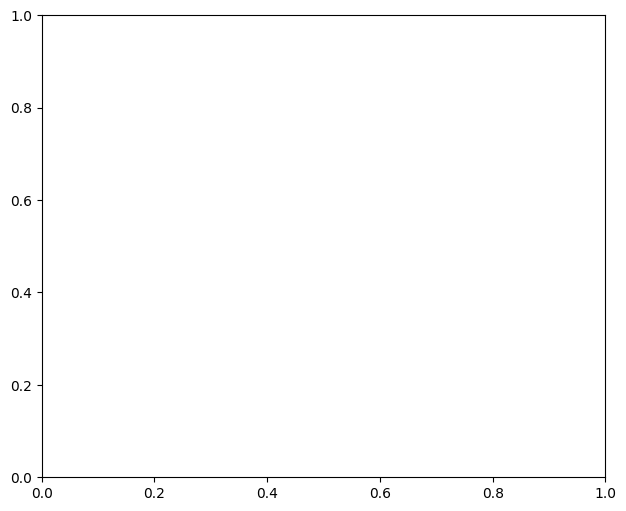

In [ ]:
    
# Plot results (existing plotting code continues from here...)
pltTitle = dataName + " Causal Inference Model Fit"
plt.figure(figsize=(16, 6))
for i, standardLevel in enumerate(uniqueStandard):
    for j, audioNoiseLevel in enumerate(sorted(uniqueSensory)):

        for k, conflictLevel in enumerate(uniqueConflict):
            plt.subplot(1, 2, j+1)
            lambda_, sigma_av_a, sigma_av_v, p_c = getParamsCausal(fittedParams, conflictLevel, audioNoiseLevel)
            x = np.linspace(-0.5, 0.5, 100)
            S_a_s=0.5
            #c_arr=np.full_like(x, conflictLevel)
            S_v_s= S_a_s+conflictLevel
            y= np.zeros_like(x)
            for i in range(len(x)):
                y[i] = probTestLonger([S_a_s,S_a_s+x[i],S_v_s,S_a_s+x[i]], sigma_av_a, sigma_av_v, p_c, lambda_)

            color = sns.color_palette("viridis", as_cmap=True)(k / len(uniqueConflict))
            plt.plot(x, y, color=color, label=f"c: {int(conflictLevel*1000)}, $\sigma_a$: {sigma_av_a:.2f}, $\sigma_v$: {sigma_av_v:.2f}", linewidth=4)
            
            plt.axvline(x=0, color='gray', linestyle='--')
            plt.axhline(y=0.5, color='gray', linestyle='--')
            plt.xlabel(f"({intensityVariable}) Test(stair-a)-Standard(a) Duration Difference")
            plt.ylabel("P(chose test)")
            plt.title(f"{pltTitle} AV,A Duration Comp. Noise: {audioNoiseLevel}", fontsize=16)
            plt.legend(fontsize=14, title_fontsize=14)
            plt.grid()

            groupedData = groupByChooseTest(data[(data[standardVar] == standardLevel) & (data[sensoryVar] == audioNoiseLevel) & (data[conflictVar] == conflictLevel)], [intensityVariable, sensoryVar, standardVar, conflictVar,visualStandardVar, visualTestVar, audioTestVar])
            bin_and_plot(groupedData, bin_method='cut', bins=10, plot=True, color=color)
            plt.text(0.05, 0.8, f"$\sigma_a$: {sigma_av_a:.2f}, $\sigma_v$: {sigma_av_v:.2f},", fontsize=12, ha='left', va='top', transform=plt.gca().transAxes)
            plt.tight_layout()
            plt.grid(True)
            print(f"Noise: {audioNoiseLevel}, Conflict: {conflictLevel}, Lambda: {lambda_:.3f}, Sigma_a: {sigma_av_a:.3f}, Sigma_v: {sigma_av_v:.3f}, p_c: {p_c:.3f}")
        plt.text(0.15, 0.9, f"P(C=1): {p_c:.2f}", fontsize=12, ha='center', va='bottom', transform=plt.gca().transAxes)
plt.show()



In [ ]:


def plot_posterior_vs_conflict(data,fittedParams,snr_list=[1.2, 0.1]):

	delta_dur_values = data["deltaDurS"].values
	conflict_values = data["conflictDur"].values
	snr_values = data["audNoise"].values
	best_params = fittedParams  # Use the best fitted parameters from the previous fitting

	posterior_values = []
	for delta, conflict, snr in zip(delta_dur_values, conflict_values, snr_values):
		λ, σa, σv, pc = getParamsCausal(best_params, conflict, snr)
		S_std = 0.5
		S_test = S_std + delta
		S_v = S_std + conflict

		m_a = np.random.normal(S_std, σa)
		m_v = np.random.normal(S_v, σv)

		var_sum = σa**2 + σv**2
		likelihood_c1 = (1 / np.sqrt(2 * np.pi * var_sum)) * np.exp(-(m_a - m_v)**2 / (2 * var_sum))
		likelihood_c2 = norm.pdf(m_a, loc=S_std, scale=σa) * norm.pdf(m_v, loc=S_v, scale=σv)
		posterior = (likelihood_c1 * pc) / (likelihood_c1 * pc + likelihood_c2 * (1 - pc))

		posterior_values.append(posterior)
	posterior_values = np.array(posterior_values)

	"""
	Plot posterior probability vs conflict for given SNR values.
	snr_list: list of SNR values to plot (default: [1.2, 0.1])
	"""
	plt.figure(figsize=(8, 5))
	for idx, noisy_snr_value in enumerate(snr_list):
		mask_noisy = np.isclose(snr_values, noisy_snr_value)
		conflicts_noisy = conflict_values[mask_noisy]
		posteriors_noisy = np.array(posterior_values)[mask_noisy]
		print(f" Posteriors: {posteriors_noisy}")
		print(f" Conflicts: {conflicts_noisy}")
		plt.subplot(1, 2, idx + 1)
		plt.scatter(conflicts_noisy * 1000, posteriors_noisy, alpha=0.6, label=f'Posterior P(C=1) (SNR={noisy_snr_value})')
		# also plot the mean posterior probability for the noisy SNR value for each conflict
		# Calculate mean posterior for each unique conflict value at this SNR
		unique_conflicts = np.unique(conflicts_noisy)
		mean_posteriors = [posteriors_noisy[conflicts_noisy == c].mean() for c in unique_conflicts]
		plt.plot(unique_conflicts * 1000, mean_posteriors, color='black', linewidth=2, marker='o', label='Mean Posterior')
		
		plt.xlabel('Conflict (ms)')
		plt.ylabel('Posterior Probability of Common Cause')
		plt.title(f'Posterior P(C=1) vs Conflict (SNR={noisy_snr_value})')
		# Use the mean P(C=1) for the axhline
		p_c_mean = np.mean([getParamsCausal(fittedParams, c, noisy_snr_value)[3] for c in conflicts_noisy])
		plt.axhline(y=p_c_mean, color='gray', linestyle='--', label=f'Mean P(C=1)={p_c_mean:.2f}')
		plt.legend()
		plt.ylim(0, 1)
		plt.grid()
	plt.tight_layout()
	plt.show()

# Plot posterior vs conflict for SNR values 1.2 and 0.1
plot_posterior_vs_conflict(data,fittedParams,snr_list=[ 0.1,1.2])


NameError: name 'fittedParams' is not defined

In [ ]:
def calculate_mu_from_data_and_model(data, fittedParams):
	"""
	Calculate mu (PSE) from both data and model predictions for each SNR and conflict condition.
	"""
	# Get unique conditions
	unique_snr = sorted(data['audNoise'].unique())
	unique_conflict = sorted(data['conflictDur'].unique())
	
	mu_data = {}
	mu_model = {}
	
	# Calculate mu for each condition
	for snr in unique_snr:
		mu_data[snr] = {}
		mu_model[snr] = {}
		
		for conflict in unique_conflict:
			# Filter data for current condition
			condition_data = data[(data['audNoise'] == snr) & (data['conflictDur'] == conflict)]
			
			if len(condition_data) > 0:
				# Group data by delta duration
				grouped = condition_data.groupby('deltaDurS').agg({
					'chose_test': 'sum',
					'responses': 'count'
				}).reset_index()
				grouped['p_choose_test'] = grouped['chose_test'] / grouped['responses']
				
				# Fit psychometric function to get mu from data
				if len(grouped) > 3:  # Need enough points to fit
					try:
						# Estimate initial guesses
						init_guess = estimate_initial_guesses(
							grouped['deltaDurS'].values,
							grouped['chose_test'].values,
							grouped['responses'].values
						)
						
						# Fit psychometric function
						fitted_params_data = fit_psychometric_function(
							grouped['deltaDurS'].values,
							grouped['chose_test'].values,
							grouped['responses'].values,
							init_guess
						)
						mu_data[snr][conflict] = fitted_params_data[1]  # mu is second parameter
						
					except:
						mu_data[snr][conflict] = np.nan
				else:
					mu_data[snr][conflict] = np.nan
				
				# Get mu from causal inference model
				lambda_, sigma_av_a, sigma_av_v, p_c = getParamsCausal(fittedParams, conflict, snr)
				
				# Calculate model's effective mu by finding where P(choose test) = 0.5
				delta_range = np.linspace(-0.5, 0.5, 1000)
				p_values = []
				
				for delta in delta_range:
					p = probTestLonger_vectorized(delta, conflict, lambda_, sigma_av_a, sigma_av_v, p_c)
					p_values.append(p)
				
				p_values = np.array(p_values)
				# Find delta where p is closest to 0.5
				idx_closest = np.argmin(np.abs(p_values - 0.5))
				mu_model[snr][conflict] = delta_range[idx_closest]
			
			else:
				mu_data[snr][conflict] = np.nan
				mu_model[snr][conflict] = np.nan
	
	return mu_data, mu_model

def plot_mu_comparison(mu_data, mu_model, unique_snr, unique_conflict):
	"""
	Plot comparison of mu values from data vs model predictions.
	"""
	fig, axes = plt.subplots(1, 2, figsize=(15, 6))
	
	colors = sns.color_palette("viridis", n_colors=len(unique_conflict))
	
	for i, snr in enumerate(unique_snr):
		ax = axes[i]
		
		conflicts_plot = []
		mu_data_plot = []
		mu_model_plot = []
		
		for j, conflict in enumerate(unique_conflict):
			if not np.isnan(mu_data[snr][conflict]) and not np.isnan(mu_model[snr][conflict]):
				conflicts_plot.append(conflict * 1000)  # Convert to ms
				mu_data_plot.append(mu_data[snr][conflict] * 1000)  # Convert to ms
				mu_model_plot.append(mu_model[snr][conflict] * 1000)  # Convert to ms
		
		if conflicts_plot:
			# Plot data mu
			ax.scatter(conflicts_plot, mu_data_plot, 
					  color='red', s=100, alpha=0.7, 
					  label='Data μ (PSE)', marker='o')
			
			# Plot model mu
			ax.scatter(conflicts_plot, mu_model_plot, 
					  color='blue', s=100, alpha=0.7, 
					  label='Model μ (PSE)', marker='s')
			
			# Connect corresponding points
			for k in range(len(conflicts_plot)):
				ax.plot([conflicts_plot[k], conflicts_plot[k]], 
					   [mu_data_plot[k], mu_model_plot[k]], 
					   'gray', alpha=0.5, linestyle='--')
		
		ax.axhline(y=0, color='black', linestyle='-', alpha=0.3)
		ax.axvline(x=0, color='black', linestyle='-', alpha=0.3)
		ax.set_xlabel('Visual Conflict (ms)')
		ax.set_ylabel('μ (PSE) (ms)')
		ax.set_title(f'Data vs Model μ (SNR={snr})')
		# limits
		ax.set_ylim(-300, 300)
		ax.legend()
		ax.grid(True, alpha=0.3)
	
	plt.tight_layout()
	plt.show()
	
	# Print numerical comparison
	print("\n=== Mu (PSE) Comparison: Data vs Model ===")
	print("SNR\tConflict(ms)\tData μ(ms)\tModel μ(ms)\tDifference(ms)")
	print("-" * 60)
	
	for snr in unique_snr:
		for conflict in unique_conflict:
			if not np.isnan(mu_data[snr][conflict]) and not np.isnan(mu_model[snr][conflict]):
				data_mu_ms = mu_data[snr][conflict] * 1000
				model_mu_ms = mu_model[snr][conflict] * 1000
				diff_ms = data_mu_ms - model_mu_ms
				print(f"{snr}\t{conflict*1000:.0f}\t\t{data_mu_ms:.2f}\t\t{model_mu_ms:.2f}\t\t{diff_ms:.2f}")

def plot_mu_vs_conflict_detailed(mu_data, mu_model, unique_snr, unique_conflict):
	"""
	Create a more detailed plot showing mu vs conflict with trend lines.
	"""
	plt.figure(figsize=(12, 8))
	
	for i, snr in enumerate(unique_snr):
		plt.subplot(2, 2, i+1)
		
		conflicts_ms = []
		mu_data_ms = []
		mu_model_ms = []
		
		for conflict in unique_conflict:
			if not np.isnan(mu_data[snr][conflict]) and not np.isnan(mu_model[snr][conflict]):
				conflicts_ms.append(conflict * 1000)
				mu_data_ms.append(mu_data[snr][conflict] * 1000)
				mu_model_ms.append(mu_model[snr][conflict] * 1000)
		
		if conflicts_ms:
			# Plot with trend lines
			plt.plot(conflicts_ms, mu_data_ms, 'ro-', linewidth=2, markersize=8, 
					label='Data μ', alpha=0.8)
			plt.plot(conflicts_ms, mu_model_ms, 'bs-', linewidth=2, markersize=8, 
					label='Model μ', alpha=0.8)
			
			# Calculate correlation
			if len(conflicts_ms) > 2:
				corr_data = np.corrcoef(conflicts_ms, mu_data_ms)[0,1]
				corr_model = np.corrcoef(conflicts_ms, mu_model_ms)[0,1]
				plt.text(0.05, 0.95, f'Data r={corr_data:.3f}\nModel r={corr_model:.3f}', 
						transform=plt.gca().transAxes, fontsize=10,
						verticalalignment='top', bbox=dict(boxstyle='round', facecolor='white', alpha=0.8))
		
		plt.axhline(y=0, color='black', linestyle='-', alpha=0.3)
		plt.axvline(x=0, color='black', linestyle='-', alpha=0.3)
		plt.xlabel('Visual Conflict (ms)')
		plt.ylabel('μ (PSE) (ms)')
		plt.title(f'μ vs Conflict (SNR={snr})')
		plt.legend()
		plt.grid(True, alpha=0.3)
		plt.ylim(-300, 300)
	
	# Correlation plot
	plt.subplot(2, 2, len(unique_snr)+1)
	all_data_mu = []
	all_model_mu = []
	
	for snr in unique_snr:
		for conflict in unique_conflict:
			if not np.isnan(mu_data[snr][conflict]) and not np.isnan(mu_model[snr][conflict]):
				all_data_mu.append(mu_data[snr][conflict] * 1000)
				all_model_mu.append(mu_model[snr][conflict] * 1000)
	
	if all_data_mu:
		plt.scatter(all_data_mu, all_model_mu, s=100, alpha=0.7)
		
		# Add diagonal line (perfect correlation)
		min_val = min(min(all_data_mu), min(all_model_mu))
		max_val = max(max(all_data_mu), max(all_model_mu))
		plt.plot([min_val, max_val], [min_val, max_val], 'k--', alpha=0.5, label='Perfect correlation')
		
		# Calculate overall correlation
		overall_corr = np.corrcoef(all_data_mu, all_model_mu)[0,1]
		plt.text(0.05, 0.95, f'Overall r={overall_corr:.3f}', 
				transform=plt.gca().transAxes, fontsize=12,
				verticalalignment='top', bbox=dict(boxstyle='round', facecolor='white', alpha=0.8))
		
		plt.xlabel('Data μ (ms)')
		plt.ylabel('Model μ (ms)')
		plt.title('Data vs Model μ Correlation')
		plt.legend()
		plt.grid(True, alpha=0.3)
		plt.ylim(-300, 300)
	
	plt.tight_layout()
	plt.show()

# Calculate mu from both data and model
print("Calculating mu (PSE) from data and model predictions...")
mu_data, mu_model = calculate_mu_from_data_and_model(data, fittedParams)

# Get unique values for plotting
unique_snr = sorted(data['audNoise'].unique())
unique_conflict = sorted(data['conflictDur'].unique())

# Create comparison plots
plot_mu_comparison(mu_data, mu_model, unique_snr, unique_conflict)
plot_mu_vs_conflict_detailed(mu_data, mu_model, unique_snr, unique_conflict)

Calculating mu (PSE) from data and model predictions...


NameError: name 'probTestLonger_vectorized' is not defined